In [2]:
!pip install pysindy

In [1]:
import numpy as np
import scipy as sp
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.gridspec as gridspec

import pickle

from keras.layers import Input, Dense
from keras import regularizers, models, optimizers
import tensorflow as tf

import sklearn
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import pysindy as ps

In [2]:
#Code to us LaTeX in Colab
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib as mpl

rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


Performing nonlinear PCA using nonlinear autoencoder





In [5]:
def loadMGFile(kkk):

    filename = "MGdata_NT_Stall" + str(kkk) + ".pickle"
    file = open(filename, 'rb')
    data = pickle.load(file)
    
    #Extract data from file
    G = data[0][2000:,:]
    Phi = np.expand_dims(data[1],0)
    Phi = Phi[:,2000:]
    Psi = np.expand_dims(data[2],0)
    Psi = Psi[:,2000:]
    T = data[3]
    N = data[4]
    para = data[5]
    gamma = data[6]
    para['gamma'] = gamma
    dt = 0.1
    t = np.arange(0,T-200,dt)

    CombinedData = np.concatenate((np.transpose(G), Phi, Psi), axis=0)
    CombinedData = np.transpose(CombinedData)

    return CombinedData, t

In [6]:
#Using the architecture from Matthias Scholz' Diplomathesis
#http://www.matthias-scholz.de/scholz_vigario_NLPCA_esann2002.pdf
#Not using his hierarchical cost function because we are reducing to 2 dimensions

def NLAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=20, batch_size = 4):

  outside_nodes = 514
  middle_nodes = 64
  hidden_nodes = 2

  input = Input(shape=(outside_nodes,))

  layer1 = Dense(middle_nodes, activation='tanh',
                kernel_regularizer=regularizers.l2(regularization))(input)
  layer2 = Dense(hidden_nodes, activation='linear',
                kernel_regularizer=regularizers.l2(regularization))(layer1)
  layer3 = Dense(middle_nodes, activation='tanh',
               kernel_regularizer=regularizers.l2(regularization))(layer2)
  output = Dense(outside_nodes, activation='linear',
               kernel_regularizer=regularizers.l2(regularization))(layer3)

  NL_autoencoder = models.Model(input,output)
  NL_autoencoder.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='mean_squared_error')
  NL_autoencoder.fit(y, y, epochs=epochs, batch_size=batch_size, shuffle=True)
  
  return NL_autoencoder

In [7]:
hidden_dim = 2
K = 10
train_data_list = []
for iii in range(0,K):
  [data, t] = loadMGFile(iii)
  train_data_list.append(data)

In [8]:
NLPCA_score_list = []
model_list = []
kfold = sklearn.model_selection.KFold(K)

import time
start = time.time()
for (test,train) in kfold.split(train_data_list):
  model = NLAE(train_data_list[train[0]], hidden_dim)
  model_list.append(model)
  
  #test data
  NLPCA_score = 0
  for iii in test:
    test_data = train_data_list[iii]
    NLPCA_score += model.evaluate(train_data_list[iii])

  NLPCA_score = NLPCA_score/(K-1)
  NLPCA_score_list.append(NLPCA_score)

(w1,b1,w2,b2,w3,b3,w4,b4) = model_list[np.argmin(NLPCA_score_list)].get_weights()
end = time.time()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
750/750 [==============================] - 16s 2ms/step - loss: 0.1384
Epoch 2/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0380
Epoch 3/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 4/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0167
Epoch 5/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0150
Epoch 6/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0138
Epoch 7/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0127
Epoch 8/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0118
Epoch 9/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 10/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0106
Epoch 11/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0102
Epoch 12/20
750/750 [==============================] - 2s 2ms/step - loss: 0.0099
Epoch 13/20
750/750 [===

In [9]:
print("Time: " + str(end-start))

Time: 432.226416349411


In [10]:
def NL_encoder(input):
  a1 = np.matmul(input,w1) + b1
  a2 = np.matmul(np.tanh(a1),w2) + b2
  return a2

def NL_decoder(input):
  a1 = np.matmul(input,w3) + b3
  a2 = np.matmul(np.tanh(a1),w4) + b4
  return a2

In [11]:
a_NLPCA_list = []
restored_data_list = []
for iii in range(0,K):
  reduced_data = NL_encoder(train_data_list[iii])
  restored_data = NL_decoder(reduced_data)

  a_NLPCA_list.append(reduced_data)
  restored_data_list.append(restored_data)

In [12]:
def plot_restored(true_data,restored_data):

    import matplotlib as mpl
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = "Computer Modern Roman"
    
    G = true_data[:,0:-2]
    Phi = true_data[:,-2]
    Psi = true_data[:,-1]
    SimG = restored_data[:,0:-2]
    SimPhi = restored_data[:,-2]
    SimPsi = restored_data[:,-1]

    L = 2*np.pi
    N = 512
    tht2 = np.linspace(-L/2,L/2,N+1)
    tht = tht2[0:N]
    
    fig = plt.figure(figsize=(8,10))
    gs = gridspec.GridSpec(6,2)

    ax = fig.add_subplot(gs[0,:])
    ax.text(-0.125, 1, '(a)', transform=ax.transAxes, size=20, weight='bold')
    plt.plot(t,Phi,label=r'True $\Phi(t)$')
    plt.plot(t,SimPhi,label=r'Restored $\Phi(t)$')
    plt.ylim(0,1)
    plt.xlabel(r'$t$')
    plt.legend()

    ax = fig.add_subplot(gs[1,:])
    ax.text(-0.125, 1, '(b)', transform=ax.transAxes, size=20, weight='bold')
    plt.plot(t,Psi,label=r'True $\Psi(t)$')
    plt.plot(t,SimPsi,label=r'Restored $\Psi(t)$')
    plt.ylim(0,1)
    plt.xlabel(r'$t$')
    plt.legend()
    
    ax = fig.add_subplot(gs[2:4,0])
    ax.text(-0.25, 1, '(c)', transform=ax.transAxes, size=20, weight='bold')
    plt.plot(tht,G[0*10,:],label=r'True $g(t=0,\theta)$')
    plt.plot(tht,SimG[0*10,:],label=r'Restored $g(t=0,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
    ax = fig.add_subplot(gs[2:4,1])
    plt.plot(tht,G[1000,:],label=r'True $g(t=100,\theta)$')
    plt.plot(tht,SimG[1000,:],label=r'Restored $g(t=100,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
    ax = fig.add_subplot(gs[4:6,0])
    plt.plot(tht,G[2000,:],label=r'True $g(t=200,\theta)$')
    plt.plot(tht,SimG[2000,:],label=r'Restored $g(t=200,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
    ax = fig.add_subplot(gs[4:6,1])
    plt.plot(tht,G[3000-1,:],label=r'True $g(t=300,\theta)$')
    plt.plot(tht,SimG[3000-1,:],label=r'Restored $g(t=300,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])

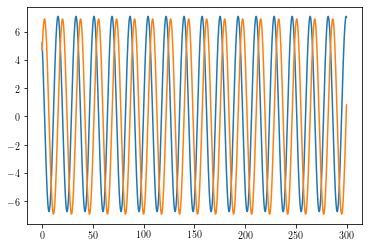

In [13]:
rand_idx = np.random.randint(0,K)
dt = 0.1
t = np.arange(0,300,dt)
plt.plot(t, a_NLPCA_list[rand_idx][:,0])
plt.plot(t, a_NLPCA_list[rand_idx][:,1])

In [14]:
#define count terms
def count_terms(model):
    coeffs = model.coefficients()
    zero_threshold = 1e-6
    new_coeffs = np.where(np.abs(coeffs)<zero_threshold, 0, coeffs)
    rowidx,colidx = np.nonzero(new_coeffs)
    num_terms = len(rowidx)
    print(str(num_terms) + " nonzero coefficients in this system of DEs")
    return num_terms

#define score
def calc_score(model,Data,t):
    true_data = model.differentiate(Data,t)
    pred_data = model.predict(Data)
    xdotscore = sklearn.metrics.r2_score(true_data, pred_data)
    print("xdot score: " + str(xdotscore))
    
    return xdotscore

In [15]:
def integrateSINDy(model, t, InputData, dt):
    diffData = model.predict(InputData)
    rhs = lambda t,x: model.predict(x[np.newaxis,:])[0]
    SimData = np.zeros((len(t),np.shape(InputData)[1]))
    SimData[0,:] = InputData[0,:]
    for iii in range(1,len(t)):
        SimData[iii,:] = SimData[iii-1,:] + dt*diffData[iii,:]
    for iii in range(0,np.shape(InputData)[1]):
        f = lambda x, a, b: a*x + b
        vars, dummy = sp.optimize.curve_fit(f, t, SimData[:,iii])
        SimData[:,iii] = SimData[:,iii] - f(t,vars[0], vars[1])
        SimData[:,iii] = SimData[:,iii] - SimData[0,iii] + InputData[0,iii]
    return SimData

In [16]:
def plotSINDy(t,Data,t_int,SimData):

    #Plot SINDY simulation
    import matplotlib as mpl
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['font.size'] = 14

    fig = plt.figure(figsize=(20,2*hidden_dim))
    gs = gridspec.GridSpec(hidden_dim,1)

    for iii in range(0,hidden_dim):
      ax = fig.add_subplot(gs[iii])
      ax.plot(t, Data[:, iii],"b", label="reduced data")
      ax.plot(t_int,SimData[:,iii], "r", label="SINDy interpolation of reduced data")
      ax.set_ylabel(feature_names[iii]+'(t)', fontsize = 20)
      if iii == 1:
        ax.legend(loc="lower right")

In [17]:
def plot_tradeoff(alpha_range, scores, num_terms):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('alpha')
  ax1.set_ylabel('x-dot score', color=color)
  ax1.plot(alpha_range, scores, '.-', color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('number of terms', color=color)  # we already handled the x-label with ax1
  ax2.plot(alpha_range, num_terms, '.-', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

In [18]:
hidden_dim = 2
dt = 0.1

feature_names = []
for iii in range(0,hidden_dim):
    feature_names.append("a" + str(iii+1))
differentiation_method = ps.SmoothedFiniteDifference(order=1)
feature_library3 = ps.PolynomialLibrary(degree=3, include_bias = True)  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168931495963427, tolerance: 0.9070896027581996
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217805610059671, tolerance: 0.9060113876256048
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.295629640970815, tolerance: 0.9070896027581996
  positive)


xdot score: 0.9999853453073607
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853453073607
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2750332924760603, tolerance: 0.9060113876256048
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2648498008416575, tolerance: 0.9070896027581996
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2284342095945038, tolerance: 0.9060113876256048
  positive)


xdot score: 0.9999853453073607
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853453073607
16 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397573421764
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.917179639736083, tolerance: 0.9053954132107207
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9222589578752811, tolerance: 0.9077454786773782
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2945054263279256, tolerance: 0.9053954132107207
  positive)


xdot score: 0.9999854452277448
16 nonzero coefficients in this system of DEs
xdot score: 0.9999854452277448
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2769090351281684, tolerance: 0.9077454786773782
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.261288455358083, tolerance: 0.9053954132107207
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.232160277755081, tolerance: 0.9077454786773782
  positive)


xdot score: 0.9999854452277448
16 nonzero coefficients in this system of DEs
xdot score: 0.9999854452277448
16 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395892736223
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9169177217727371, tolerance: 0.9069428762959216
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217829820590633, tolerance: 0.9061791812215576
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2955295929500876, tolerance: 0.9069428762959216
  positive)


xdot score: 0.9999853529979903
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853529979903


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.275101946651711, tolerance: 0.9061791812215576
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2645286819270314, tolerance: 0.9069428762959216
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2286381941808215, tolerance: 0.9061791812215576
  positive)


16 nonzero coefficients in this system of DEs
xdot score: 0.9999853529979903
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853529979903
16 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397664232426
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9183479275922362, tolerance: 0.9132119309086124
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9202424963774111, tolerance: 0.9002712138697924
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3014796681113423, tolerance: 0.9132119309086124
  positive)


xdot score: 0.999985417332576
16 nonzero coefficients in this system of DEs
xdot score: 0.999985417332576
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2697765741480063, tolerance: 0.9002712138697924
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2779236695714018, tolerance: 0.9132119309086124
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.216255505933907, tolerance: 0.9002712138697924
  positive)


xdot score: 0.999985417332576
16 nonzero coefficients in this system of DEs
xdot score: 0.999985417332576
16 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395417226942
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168683283747117, tolerance: 0.90723890598881
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217748446888419, tolerance: 0.9058396246226273
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2957262164304924, tolerance: 0.90723890598881
  positive)


xdot score: 0.9999853382284472
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853382284472
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2749535402244359, tolerance: 0.9058396246226273
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.26516435172011, tolerance: 0.90723890598881
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2282283396906324, tolerance: 0.9058396246226273
  positive)


xdot score: 0.9999853382284472
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853382284472
16 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397488994849
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9183039189969271, tolerance: 0.9130244006781711
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9202651024312043, tolerance: 0.9004462018467962
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3013399941333983, tolerance: 0.9130244006781711
  positive)


xdot score: 0.9999854106075965
16 nonzero coefficients in this system of DEs
xdot score: 0.9999854106075965
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2699650567662037, tolerance: 0.9004462018467962
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2776184101287615, tolerance: 0.9130244006781711
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.216733734515469, tolerance: 0.9004462018467962
  positive)


xdot score: 0.9999854106075965
16 nonzero coefficients in this system of DEs
xdot score: 0.9999854106075965
16 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395331428269
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168877236759077, tolerance: 0.9071221405070518
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217796273998058, tolerance: 0.9059740371828641
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2956511228694592, tolerance: 0.9071221405070518
  positive)


xdot score: 0.9999853436991379
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853436991379
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2750160502748547, tolerance: 0.9059740371828641
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2649193889163775, tolerance: 0.9071221405070518
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2283893039939155, tolerance: 0.9059740371828641
  positive)


xdot score: 0.9999853436991379
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853436991379
16 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397554197018
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9182371399567555, tolerance: 0.9127399056714669
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9203237647623197, tolerance: 0.9007114197945582
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3011293562988122, tolerance: 0.9127399056714669
  positive)


xdot score: 0.9999853990863053
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853990863053
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2702688355835359, tolerance: 0.9007114197945582
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2771593139225548, tolerance: 0.9127399056714669
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.217467480690411, tolerance: 0.9007114197945582
  positive)


xdot score: 0.9999853990863053
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853990863053
16 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs
xdot score: 0.9999395168302041
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9169141577939623, tolerance: 0.9069640932431178
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217827901654776, tolerance: 0.9061549860566779
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2955443678750944, tolerance: 0.9069640932431178
  positive)


xdot score: 0.9999853518424697
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853518424697
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.275093246718688, tolerance: 0.9061549860566779
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2645758895994599, tolerance: 0.9069640932431178
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2286084763736296, tolerance: 0.9061549860566779
  positive)


xdot score: 0.9999853518424697
16 nonzero coefficients in this system of DEs
xdot score: 0.9999853518424697
16 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs
xdot score: 0.9999397650784687
14 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9184582449799596, tolerance: 0.913477493181923
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9207330352767685, tolerance: 0.8997911430320282
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.301728876365704, tolerance: 0.913477493181923
  positive)


xdot score: 0.999985400603645
16 nonzero coefficients in this system of DEs
xdot score: 0.999985400603645
16 nonzero coefficients in this system of DEs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2705241830712435, tolerance: 0.8997911430320282
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2783162923489584, tolerance: 0.913477493181923
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.217218559411534, tolerance: 0.8997911430320282
  positive)


xdot score: 0.999985400603645
16 nonzero coefficients in this system of DEs
xdot score: 0.999985400603645
16 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs
xdot score: 0.9999394402096654
14 nonzero coefficients in this system of DEs


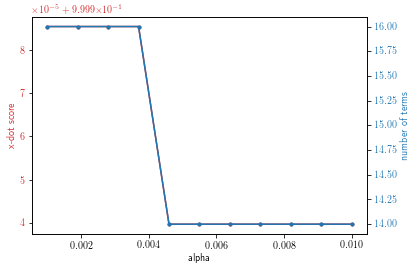

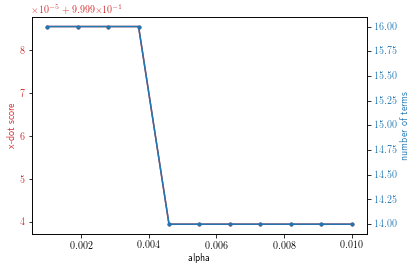

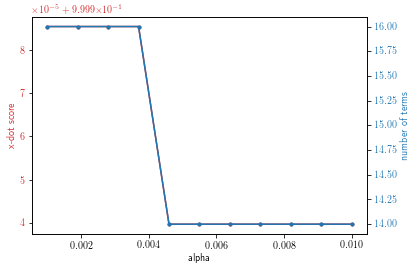

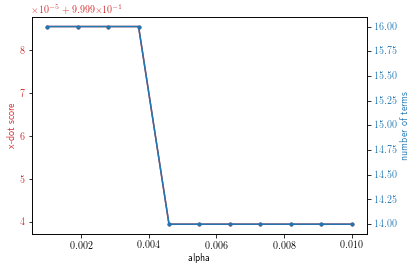

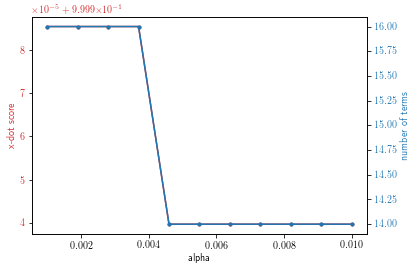

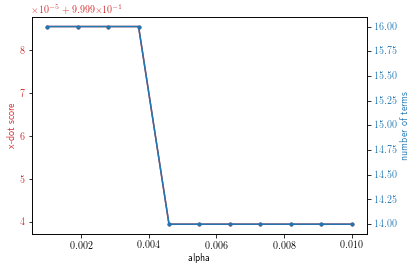

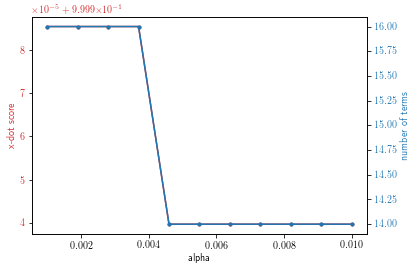

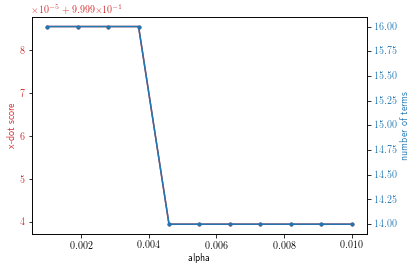

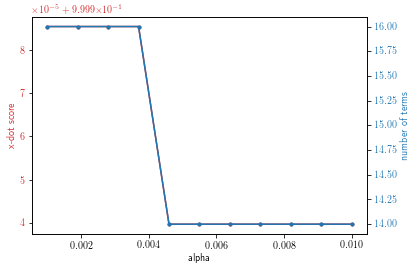

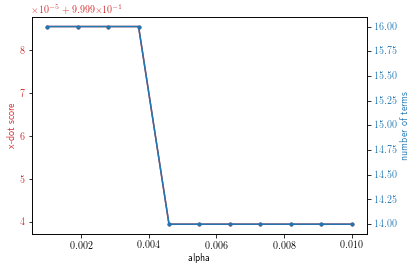

In [21]:
#find best SINDy equations for POD data
alpha_range = np.linspace(0.001,0.01,11)
NLPCA_SINDy_alpha_list = []

for iii in range(0,K):
  alpha_score_list = []
  num_terms_list = []
  for jjj in range(0,len(alpha_range)):
    lasso_optimizer = Lasso(alpha=alpha_range[jjj], fit_intercept=False, selection="cyclic", max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 

    test_model.fit(a_NLPCA_list[iii], t=t)
    alpha_score_list.append(calc_score(test_model,a_NLPCA_list[iii],t))
    num_terms_list.append(count_terms(test_model))
  
  plot_tradeoff(alpha_range, alpha_score_list, num_terms_list)
  NLPCA_SINDy_alpha_list.append(alpha_range[np.argmin(num_terms_list)])

In [23]:
#cross validation to find the best model
model_score_list = []
for (test,train) in kfold.split(train_data_list):
    lasso_optimizer = Lasso(alpha=0.001, 
                            fit_intercept=False, 
                            selection="cyclic", 
                            max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 

    test_model.fit(a_NLPCA_list[train[0]], t=t)
    val_score = 0
    for iii in test:
      val_score += calc_score(test_model,a_NLPCA_list[iii],t)
    model_score_list.append(val_score/(K-1))

best_idx = np.argmax(model_score_list)
NLPCA_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 
NLPCA_model.fit(a_NLPCA_list[best_idx],t=t)
NLPCA_model.print(precision=6)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168931495963427, tolerance: 0.9070896027581996
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217805610059671, tolerance: 0.9060113876256048
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.917179639736083, tolerance: 0.9053954132107207
  positive)


xdot score: 0.999985442899531
xdot score: 0.9999853529712364
xdot score: 0.9999854108717815
xdot score: 0.9999853382005615
xdot score: 0.9999854047655311
xdot score: 0.999985343697814
xdot score: 0.9999853941564364
xdot score: 0.9999853518228716
xdot score: 0.9999853951784


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9222589578752811, tolerance: 0.9077454786773782
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9169177217727371, tolerance: 0.9069428762959216
  positive)


xdot score: 0.9999853429898727
xdot score: 0.999985350766706
xdot score: 0.9999854102196613
xdot score: 0.9999853357906394
xdot score: 0.9999854041326612
xdot score: 0.9999853413583131
xdot score: 0.9999853935812154
xdot score: 0.9999853496005783
xdot score: 0.9999853949245499


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217829820590633, tolerance: 0.9061791812215576
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9183479275922362, tolerance: 0.9132119309086124
  positive)


xdot score: 0.9999853452806109
xdot score: 0.9999854429840906
xdot score: 0.9999854106415889
xdot score: 0.9999853381193378
xdot score: 0.9999854045383694
xdot score: 0.999985343659175
xdot score: 0.9999853939348714
xdot score: 0.9999853518419135
xdot score: 0.9999853949098784


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9202424963774111, tolerance: 0.9002712138697924
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168683283747117, tolerance: 0.90723890598881
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217748446888419, tolerance: 0.9058396246226273
  positive)


xdot score: 0.9999853387849864
xdot score: 0.999985438002505
xdot score: 0.9999853462578474
xdot score: 0.9999853318822227
xdot score: 0.9999854105844823
xdot score: 0.9999853372191932
xdot score: 0.9999853989281418
xdot score: 0.9999853451363876
xdot score: 0.999985390033054
xdot score: 0.9999853452794724
xdot score: 0.9999854427797199
xdot score: 0.9999853528888532
xdot score: 0.999985411058568
xdot score: 0.9999854049495105
xdot score: 0.9999853436820743
xdot score: 0.9999853943351338
xdot score: 0.9999853517483253
xdot score: 0.9999853954097588
xdot score: 0.9999853394230311
xdot score: 0.9999854386585216
xdot score: 0.9999853468986959
xdot score: 0.99998541730948
xdot score: 0.9999853325176851


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9183039189969271, tolerance: 0.9130244006781711
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9202651024312043, tolerance: 0.9004462018467962
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168877236759077, tolerance: 0.9071221405070518
  positive)


xdot score: 0.9999853378566512
xdot score: 0.9999853990256639
xdot score: 0.9999853457768153
xdot score: 0.9999853908858518
xdot score: 0.9999853453060368
xdot score: 0.999985442876413
xdot score: 0.99998535295802
xdot score: 0.9999854109167174
xdot score: 0.9999853382113846

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217796273998058, tolerance: 0.9059740371828641
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9182371399567555, tolerance: 0.9127399056714669
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9203237647623197, tolerance: 0.9007114197945582
  positive)



xdot score: 0.9999854048098304
xdot score: 0.9999853941995474
xdot score: 0.999985351811367
xdot score: 0.9999853952326199
xdot score: 0.9999853403632284
xdot score: 0.9999854396559476
xdot score: 0.9999853478441676
xdot score: 0.9999854171746689
xdot score: 0.9999853334529196
xdot score: 0.9999854105470068
xdot score: 0.9999853387957307
xdot score: 0.9999853467215016
xdot score: 0.9999853921247621
xdot score: 0.9999853452877652
xdot score: 0.9999854429737814
xdot score: 0.9999853529974341
xdot score: 0.9999854106775482
xdot score: 0.9999853381343239
xdot score: 0.999985404573875
xdot score: 0.9999853436680401
xdot score: 0.9999853939695449
xdot score: 0.9999853949509901


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9169141577939623, tolerance: 0.9069640932431178
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217827901654776, tolerance: 0.9061549860566779
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9184582449799596, tolerance: 0.913477493181923
  positive)


xdot score: 0.9999853398481664
xdot score: 0.9999854394696019
xdot score: 0.9999853472842841
xdot score: 0.9999854067820378
xdot score: 0.9999853329877112
xdot score: 0.9999854008855683
xdot score: 0.9999853382912156
xdot score: 0.9999853905680689
xdot score: 0.999985346167791
a1' = -0.738101 a2 + -0.000244 a1^2 + -0.002102 a1 a2 + 0.000428 a2^2 + -0.000038 a1^3 + 0.007882 a1^2 a2 + -0.000319 a1 a2^2 + 0.007960 a2^3
a2' = 0.603523 a1 + 0.000096 a1^2 + 0.000489 a1 a2 + -0.001452 a2^2 + -0.005271 a1^3 + -0.000409 a1^2 a2 + -0.004956 a1 a2^2 + -0.000071 a2^3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9207330352767685, tolerance: 0.8997911430320282
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9168683283747117, tolerance: 0.90723890598881
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9217748446888419, tolerance: 0.9058396246226273
  positive)


In [24]:
NLPCA_model.optimizer

Lasso(alpha=0.001, fit_intercept=False, max_iter=2000)

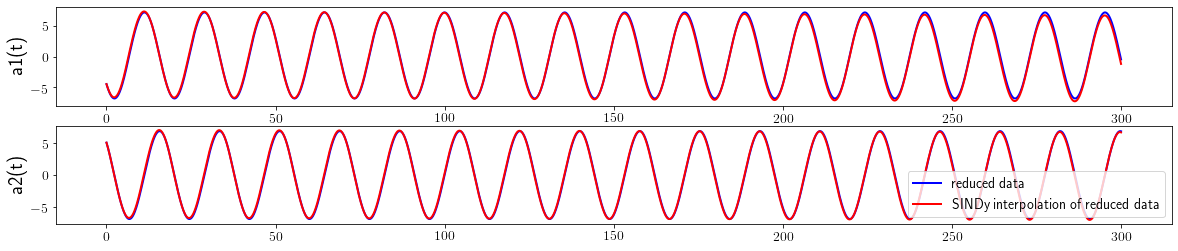

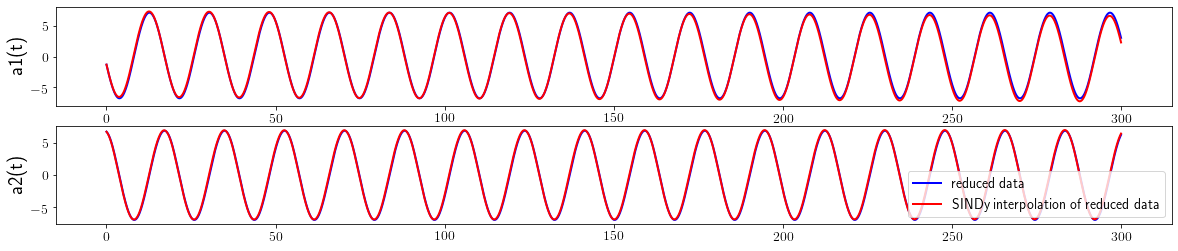

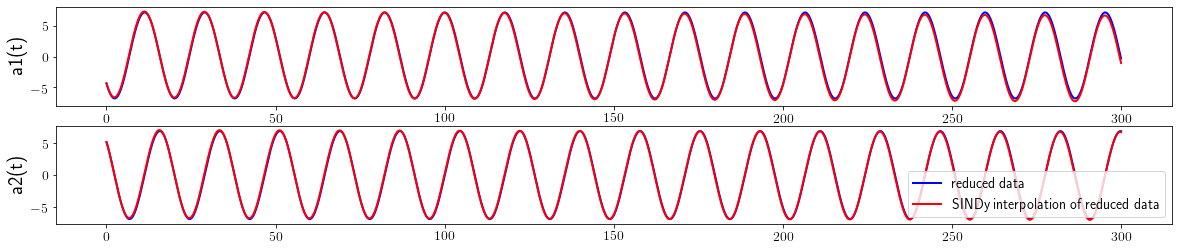

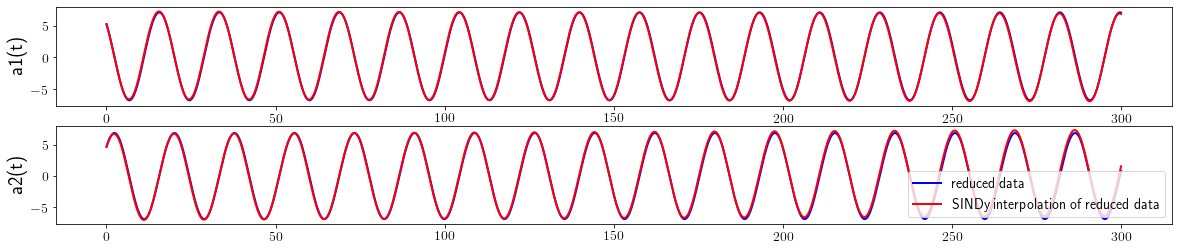

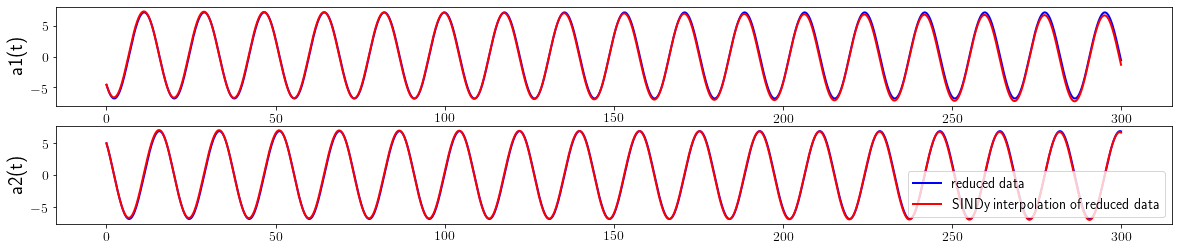

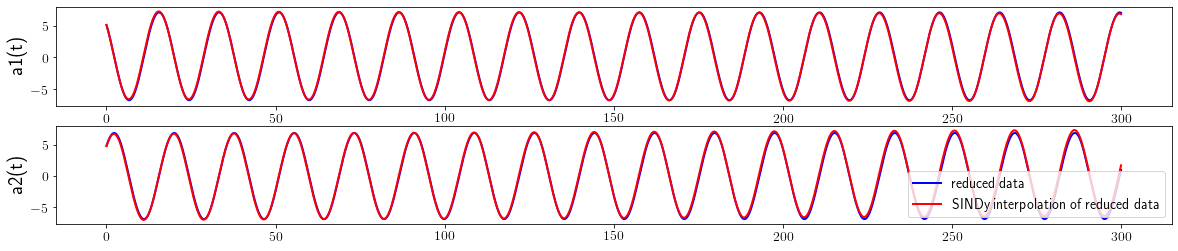

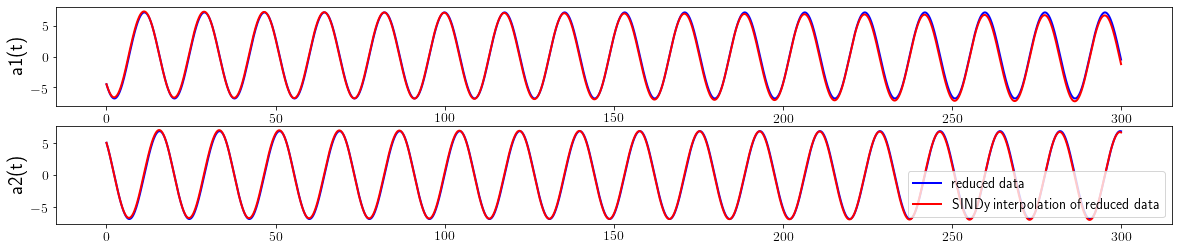

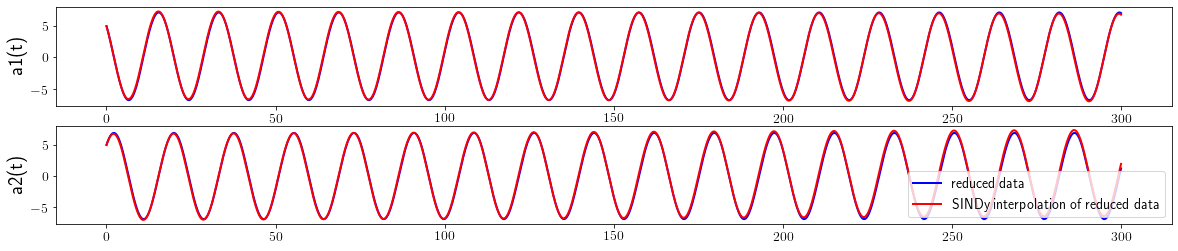

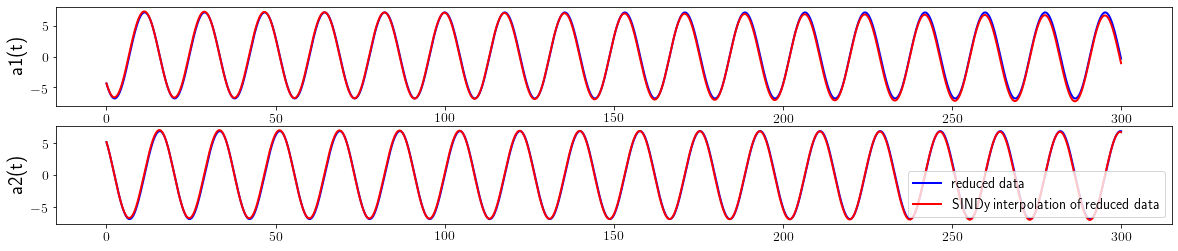

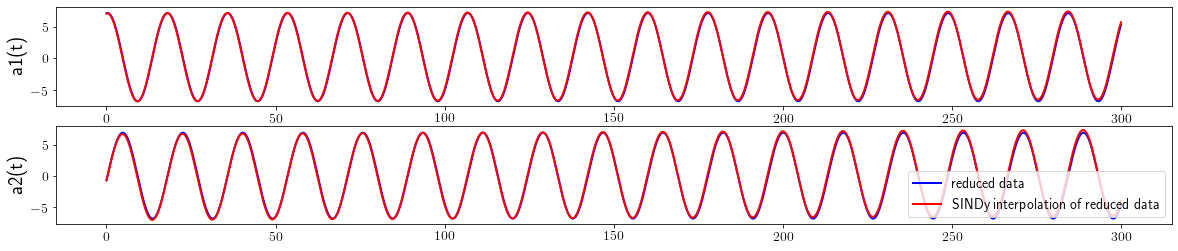

In [25]:
restored_NLPCA_data_list = []
for iii in range(0,K):
  SimData = integrateSINDy(NLPCA_model, t, a_NLPCA_list[iii], dt)
  plotSINDy(t,a_NLPCA_list[iii],t,SimData)
  restored_NLPCA_data_list.append(NL_decoder(SimData))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


0.9914691669243776
0.9887146618398603


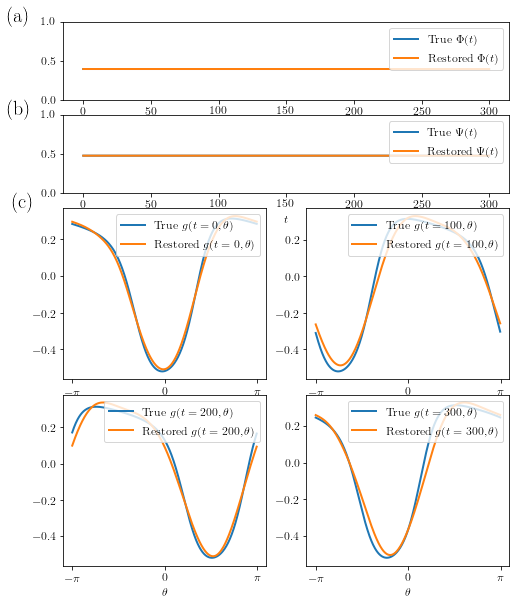

In [26]:
iii = np.random.randint(0,K)
plot_restored(train_data_list[iii],restored_NLPCA_data_list[iii])
plt.savefig('NLPCAreconstruction.pdf')

NLPCA_rec_score = 0
for iii in range(0,K):  
  restored_data = NL_decoder(a_NLPCA_list[iii])
  NLPCA_rec_score += r2_score(train_data_list[iii][:,0:-2],restored_data[:,0:-2])
NLPCA_rec_score = NLPCA_rec_score/K
print(NLPCA_rec_score)

NLPCA_rec_score = 0
for iii in range(0,K):  
  NLPCA_rec_score += r2_score(train_data_list[iii][:,0:-2],restored_NLPCA_data_list[iii][:,0:-2])
NLPCA_rec_score = NLPCA_rec_score/K
print(NLPCA_rec_score)